# Phân tích cảm xúc bình luận phim Imdb và phân loại đánh giá hình ảnh chó mèo
Trong assignment này, chúng ta sẽ xây dựng hai bộ phân loại học máy. Bộ phân loại đầu tiên được huấn luyện để nhận diện xem bình luận phim là tích cực hay tiêu cực, ở đây chúng ta sử dụng tập dữ liệu [Imdb movie reviews](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) chứa 5000 bài bình luận có một nửa là tích cực, một nửa là tiêu cực. Bộ phân loại thứ hai là phân loại hình ảnh có thể dự đoán đó hình ảnh về chó hay mèo. Chúng ta sử dụng tập dữ liệu [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/data) từ cuộc thi Dogs vs. Cats trên Kaggle gồm 25000 hình ảnh về chó và mèo. 
<br>
Mục đích chính của notebook này là chỉ cho bạn các bước cơ bản khi huấn luyện một mô hình học máy như sau:
1. Nhận dữ liệu
2. Load và tiền xử lý dữ liệu
3. Chọn mô hình
4. Huấn luyện mô hình
5. Đánh giá mô hình
6. Cải thiện mô hình

## Phân tích cảm xúc bình luận phim
Chúng ta hãy xây dựng bộ phân loại đầu tiên.

### Import libs

In [6]:
import re
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Download dữ liệu
Download tập dữ liệu [Imdb movie reviews](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) trích và đặt folder **aclImdb** vào folder **data**.

### Load tập dữ liệu

In [2]:
def load_train_test_imdb_data(data_dir):
    """Loads the IMDB train/test datasets from a folder path.
    Input:
    data_dir: path to the "aclImdb" folder.
    
    Returns:
    train/test datasets as pandas dataframes.
    """

    data = {}
    for split in ["train", "test"]:
        data[split] = []
        for sentiment in ["neg", "pos"]:
            score = 1 if sentiment == "pos" else 0

            path = os.path.join(data_dir, split, sentiment)
            file_names = os.listdir(path)
            for f_name in file_names:
                with open(os.path.join(path, f_name), "r", 
                encoding="utf-8") as f:
                    review = f.read()
                    data[split].append([review, score])
    
    # CODE CỦA BẠN Ở ĐÂY
    # Xáo trộn dữ liệu huấn luyện sử dụng "np.random.shuffle":
    np.random.shuffle(data["train"])

    # Tạo khung dữ liệu huấn luyện "data["train"])" chỉ có 2 cột: "text" và "sentiment"      
    data["train"] = pd.DataFrame(data["train"],columns=["text", "sentiment"])

    # Xáo trộn dữ liệu kiểm tra sử dụng "np.random.shuffle":
    np.random.shuffle(data["test"])

    # Tạo khung dữ liệu kiểm tra "data["test"])" chỉ có 2 cột: "text" và "sentiment"      
    data["test"] = pd.DataFrame(data["test"],columns=["text", "sentiment"])

    return data["train"], data["test"]

**load_train_test_imdb_data** giúp load các tập dữ liệu vào bên trong folder **acllmdb**.
<br>
Hoàn thành cell bên dưới để load các tập dữ liệu bên trong folder **acllmdb** bằng cách sử dụng **load_train_test_imdb_data** ở trên.
<br>
Sẽ mất vài phút để load các tập dữ liệu.
Sau khi load xong, bây giờ chúng ta có các dataframe (khung dữ liệu) **train_data** và **test_data**. 

In [3]:
# CODE CỦA BẠN Ở ĐÂY
# Load tập dữ liệu
train_data, test_data = load_train_test_imdb_data("aclImdb")
# CODE CỦA BẠN Ở ĐÂY

In ra năm mục đầu tiên và các shape của tập dữ liệu **train_data** và **test_data**.

In [4]:
# CODE CỦA BẠN Ở ĐÂY
print(train_data.iloc[:5])

# CODE CỦA BẠN Ở ĐÂY
print(test_data.iloc[:5])

                                                text  sentiment
0  I always look forward to this movie when its o...          1
1  A wealthy Harvard dude falls for a poor Radcli...          0
2  This is easily a 9. Michel Serrault, known mor...          1
3  Complete drivel. An unfortunate manifestation ...          0
4  The only connection this movie has to horror i...          0
                                                text  sentiment
0  I was -Unlike most of the reviewers- not born ...          1
1  It's hard to know exactly what to say about th...          0
2  Necessary Roughness (1991) was a bad comedy/ d...          0
3  In this horrible attempt at a Blair Witch mock...          0
4  This 1955 Producers' Showcase version of the m...          1


### Tiền xử lý bình luận
Chúng ta có hàm **clean_text** giúp dọn các bình luận do đó việc huấn luyện mô hình sẽ dễ dàng hơn. Ở đây chúng ta dọn những thứ như HTML tag, loại bỏ dấu chấm, chuyển chữ viết hoa thành chữ thường. 

In [5]:
def clean_text(text):
    """
    Applies some pre-processing on the given text.

    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    
    # loại bỏ HTML tag
    text = re.sub(r'<.*?>', '', text)
    
    # CODE CỦA BẠN Ở ĐÂY
    # loại bỏ các ký tự [\], ['] và ["] bằng phương thức resub:
    text = re.sub(r'\\', '', text)

    text = re.sub(r"'", '', text) 

    text = re.sub(r'"', '', text)   
    # CODE CỦA BẠN Ở ĐÂY
    
    # chuyển đổi văn bản thành chữ thường
    text = text.strip().lower()
    
    # thay dấu chấm bằng dấu cách
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text

# Ví dụ
clean_text("<html>This is not a sentence.<\html>").split()

['this', 'is', 'not', 'a', 'sentence']

### Biểu diễn bình luận dưới dạng vectơ
Để huấn luyện các bình luận với mô hình học máy, chúng ta cần chuyển chúng thành các vectơ. Có nhiều cách để chuyển một bình luận thành vectơ (văn bản nói chung), ở đây chúng ta sử dụng mô hình [túi từ (bag-of-words)](https://en.wikipedia.org/wiki/Bag-of-words_model) thường được dùng khi huấn luyện với các thuật toán học máy truyền thống. Chúng ta sẽ sử dụng sickit-learn [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) giúp tạo túi từ dễ dàng hơn. Hãy chạy cell bên dưới để xem ví dụ. 

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

training_texts = [
    "This is a good cat",
    "This is a bad day"
]

test_texts = [
    "This day is a good day"
]

# vectorizer này sẽ giúp bỏ qua các stop word (từ dừng)
vectorizer = CountVectorizer(
    stop_words="english",
    preprocessor=clean_text
)

# CODE CỦA BẠN Ở ĐÂY
# khớp vectorizer trong văn bản huấn luyện "training_texts"....
vectorizer.fit_transform(training_texts)
# CODE CỦA BẠN Ở ĐÂY

# lấy từ vựng của vectorizer
inv_vocab = {v: k for k, v in vectorizer.vocabulary_.items()}
vocabulary = [inv_vocab[i] for i in range(len(inv_vocab))]

# Ví dụ về vectơ hóa
pd.DataFrame(
    data=vectorizer.transform(test_texts).toarray(),
    index=["test sentence"],
    columns=vocabulary
)

,bad,cat,day,good
test sentence,0,0,2,1


### Tạo CountVectorizer
Vectorier được dùng để vectơ hóa các bình luận.

In [7]:
# Chuyển mỗi văn bản thành một vectơ đếm từ
vectorizer = CountVectorizer(stop_words="english",
                             preprocessor=clean_text)

### Biến đổi bình luận thành vectơ

Chúng ta sẽ sử dụng hàm **fit_transform** của **vectorizer** để chuyển **train_data["text"]** và **test_data["text"]** thành các vectơ.

In [8]:
# CODE CỦA BẠN Ở ĐÂY
# Chuyển bình luận thành vectơ
training_features = vectorizer.fit_transform(train_data["text"])
test_features = vectorizer.transform(test_data["text"]) 
# CODE CỦA BẠN Ở ĐÂY

### Tạo và huấn luyện mô hình
Có rất nhiều thuật toán học máy mà chúng ta có thể sử dụng trong trường hợp này. Ở đây chúng ta sử dụng Hồi quy Logistic, nó giúp huấn luyện rất nhanh và thường được sử dụng cho bài toán phân loại văn bản với tập dữ liệu nhỏ. Bạn có thể tìm hiểu thêm thông tin chi tiết về thuật toán này và nhiều thuật toán khác trong khóa học sau của chuyên ngành học máy này. Chạy cell bên dưới để tạo và huấn luyện mô hình.

In [9]:
from sklearn.svm import LinearSVC
# CODE CỦA BẠN Ở ĐÂY
# Gán "LinearSVC()" cho biến mô hình:
model = LinearSVC()

# Khớp mô hình với dữ liệu huấn luyện "training_features" và nhãn huấn luyện "train_data["sentiment"]":
model.fit(training_features,train_data["sentiment"])
# CODE CỦA BẠN Ở ĐÂY

c:\users\v\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

### Đánh giá mô hình
Chúng ta sẽ sử dụng **accuracy_score** để đánh giá mô hình trên **test_data**. Xem tra tài liệu [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) ở đây. Hãy hoàn thành code bên dưới để tính độ chính xác của mô hình trên **test_data**.

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
# CODE CỦA BẠN Ở ĐÂY
# Dự đoán tập dữ liệu kiểm tra:
y_test_pred = model.predict(test_features)
# Đánh giá
acc = accuracy_score(test_data["sentiment"], y_test_pred)
# CODE CỦA BẠN Ở ĐÂY

print("Accuracy on the IMDB dataset: {:.2f}%".format(acc*100))

Accuracy on the IMDB dataset: 83.68%


**Quizz:** Độ chính xác của mô hình trên test set là bao nhiêu?
<br>
**Đáp án:** 83.68%

### (Tùy chọn) Đánh giá mô hình sử dụng f1 score
Hoàn thành cell bên dưới để nhận điểm thưởng. Hãy sử dụng f1 score để đánh giá mô hình.

In [11]:
from sklearn.metrics import f1_score

# CODE CỦA BẠN Ở ĐÂY
# Đánh giá sử dụng f1
f1 = f1_score(test_data["sentiment"], y_test_pred)
# CODE CỦA BẠN Ở ĐÂY

print("F1 on the IMDB dataset: {:.2f}".format(f1))

F1 on the IMDB dataset: 0.83


### Cải thiện mô hình
Bây giờ, chúng ta hãy cố gắng cải thiện độ chính xác của mô hình trên test set. Có nhiều cách để cải thiện hiện mô hình học máy, ở đây chúng ta sẽ thử một phương thức khác để biểu diễn các bình luận thành các vectơ có [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) với [n-gram](https://en.wikipedia.org/wiki/N-gram). Hãy chạy cell sau để huấn luyện mô hình mới và xem độ chính xác. 

In [12]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer


# Chuyển mỗi văn bản thành một vectơ đếm từ
vectorizer = TfidfVectorizer(stop_words="english",
                             preprocessor=clean_text,
                             ngram_range=(1, 2))

training_features = vectorizer.fit_transform(train_data["text"])    
test_features = vectorizer.transform(test_data["text"])

# CODE CỦA BẠN Ở ĐÂY
# Huấn luyện
# Gán "LinearSVC()" vào một biến mô hình:
model = LinearSVC()

# Khớp mô hình với dữ liệu huấn luyện "training_features" và nhãn huấn luyện "train_data["sentiment"]":
model.fit(training_features,train_data["sentiment"])

# Dự đoán dữ liệu kiểm tra "test_features":
y_test_pred = model.predict(test_features)
# CODE CỦA BẠN Ở ĐÂY

# Đánh giá
acc = accuracy_score(test_data["sentiment"], y_test_pred)

print("Accuracy on the IMDB dataset: {:.2f}".format(acc*100))

Accuracy on the IMDB dataset: 88.66


**Quizz:** Độ chính xác của mô hình trên test set là bao nhiêu?
<br>
**Đáp án: 88.66%

### (Tùy chọn) Đánh giá mô hình đã carit hiện sử dụng f1 score
Hoàn thành cell bên dưới để nhận điểm thưởng. Sử dụng f1 score để đánh giá mô hình.

In [13]:
from sklearn.metrics import f1_score

# CODE CỦA BẠN Ở ĐÂY
# Đánh giá sử dụng f1
f1 = f1_score(test_data["sentiment"], y_test_pred)
# CODE CỦA BẠN Ở ĐÂY

print("F1 on the IMDB dataset: {:.2f}".format(f1))

F1 on the IMDB dataset: 0.89


## Phân loại hình ảnh chó mèo
Hãy xây dựng bộ phân loại hình ảnh chó-mèo thứ hai. Ở đây chúng ta sẽ sử dụng thuật toán Neural Network (mạng nơ-ron) cho bài toán phân loại ảnh này. Có nhiều kiểu kiến trúc mạng nơ-ron cho các bài toán khác nhau. Đơn giản nhất là **Mạng nơ-ron truyền thẳng (FNN)**. Với bài toán phân loại hình ảnh thì phù hợp dùng **Mạng nơ-ron tích chập (CNN)**. Tuy nhiên do khóa học này được thiết kế để giới thiệu các thuật toán Học máy căn bản mà **CNN** là một loại thuật toán nâng cao và framework mà chúng ta sử dụng trong suốt chứng chỉ là **scikit-learn** lại không hỗ trợ **CNN** nên ở đây chúng ta chỉ dùng **FNN** cho bài toán này để minh họa bài toán phân loại hình ảnh. 

### Import lib

In [7]:
import cv2

### Download tập dữ liệu
Chúng ta sẽ sử dụng tập dữ liệu [Dog vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data) từ Kaggle.
<br>
Download tập dữ liệu từ link trên (trước tiên bạn cần tạo tài khoản Kaggle để download dữ liệu).
<br>
Sau khi download bạn sẽ nhận được một file zip là **dogs-vs-cats.zip**, hãy giải nén nó.
<br>
Sau khi giải nén sẽ được 3 file. Bạn chỉ cần file **train.zip** cho assignment này.
<br>
Giải nén tất cả hình ảnh trong file **train.zip** vào folder **dog_cat_train**.
<br>
Sao chép **dog_cat_train** vào folder **data** cho assignment này.

### Load dữ liệu

In [8]:
def get_cat_dog_data(folder, image_size):
    """
    Get the cat dog data
    Inputs: folder: The folder path
            image_size: Resize all the image sizes to image_size
    
    Output: images, labels numpy array
    """
    images, labels = [], []
    
    for file in os.listdir(folder):
        # CODE CỦA BẠN Ở ĐÂY
        # Load một hình ảnh vào image_data với đường dẫn hình ảnh là "os.path.join(folder, file)":
        image_data = os.path.join(folder, file)

        # Thay đổi kích thước hình ảnh thành "(image_size, image_size)"":
        image_data = cv2.resize(cv2.imread(image_data),(image_size, image_size))

        # Nối image_data vào list images:
        images.append(image_data)
        # Nối nhãn dữ liệu "dog" hoặc "cat" vào list labels dựa theo tên "file":
        # Nếu hình ảnh về chú chó, nhãn sẽ là is 1, nếu không sẽ là 0.
        if "dog" in str(file):
            labels.append(1)
        else:
            labels.append(0)
        # CODE CỦA BẠN Ở ĐÂY
    return np.array(images), np.array(labels) 

Sử dụng hàm **get_cat_dog_data** để load dữ liệu bên trong folder **dog_cat_train**.
<br>
Sử dụng **image_size = 28** khi load dữ liệu. Ở đây chúng ta chia tỷ lệ tất cả các hình ảnh thành size 28x28.
<br>
Có thể tốn vài phút để tải hình ảnh.

In [9]:
# CODE CỦA BẠN Ở ĐÂY
images, labels = get_cat_dog_data("train", 28)
# CODE CỦA BẠN Ở ĐÂY

### In ra shape của biến **images** và **labels**

In [10]:
# CODE CỦA BẠN Ở ĐÂY
print(images.shape,labels.shape)
# CODE CỦA BẠN Ở ĐÂY

(25000, 28, 28, 3) (25000,)


Hãy hiển thị một số hình ảnh.

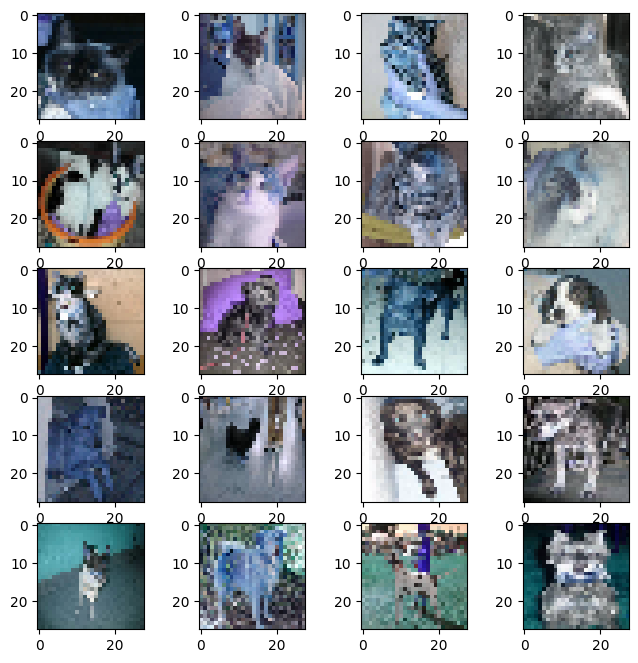

In [11]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i+12490])
plt.show()

### Tiền xử lý hình ảnh
Mỗi hình ảnh có shape 28x28x3 là một mảng ba chiều; để đưa hình ảnh vào thuật toán **FNN**, chúng ta cần chuyển đổi chúng thành mảng một chiều để có shape 2352. Chúng ta cũng chia tỷ lệ giá trị điểm ảnh theo phạm vi [0, 1].
<br>
Hoàn thành cell bên dưới. Reshape biến **images** thành shape (số lượng hình ảnh, 28*28*3). Chia tỷ lệ tất cả các giá trị thành phạm vi [0, 1] bằng cách chia cho 255.

In [12]:
# CODE CỦA BẠN Ở ĐÂY
# Reshape images, làm phẳng tất cả hình ảnh
# use the reshape function
images = images.reshape(images.shape[0],28*28*3)
print(images.shape)

# Chia tỷ lệ mọi giá trị điểm ảnh giữa 0 và 1
images = images/255
# CODE CỦA BẠN Ở ĐÂY

(25000, 2352)


### Chia tách tập dữ liệu
Hãy chia tập dữ liệu thành train/test với tỷ lệ 9:1. Chạy cell dưới đây để chia tập dữ liệu.

In [13]:
from sklearn.model_selection import train_test_split

# CODE CỦA BẠN Ở ĐÂY
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 1/9, random_state = 0)
# CODE CỦA BẠN Ở ĐÂY

In ra shape của các biến **X_train, X_test, y_train, y_test**.
<br>
In ra số lượng chó, mèo cho tập dữ liệu huấn luyện và kiểm tra cho tập dữ liệu train và test sử dụng các biến **y_train** và **y_test**.

In [14]:
# CODE CỦA BẠN Ở ĐÂY
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# CODE CỦA BẠN Ở ĐÂY

(22222, 2352) (2778, 2352) (22222,) (2778,)


### Tạo và huấn luyện mô hình
Hãy tạo và huấn luyện mô hình sử dụng **scikit-learn**. Bạn không cần lo lắng quá nhiều về chi tiết của mô hình lúc này, chúng ta sẽ nghiên cứu nó kỹ hơn trong khóa sau. Hãy chạy cell dưới đây để tạo và huấn luyện mô hình **MLPClassifier()** với các tham số: 

  * solver='adam'
  * alpha=1e-5
  * activation='relu'
  * hidden_layer_sizes=(64, 64)
  * random_state=1

Để biết thêm chi tiết về các tham số của MLPClassifier, hãy xem [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [16]:
from sklearn.neural_network import MLPClassifier

# tạo mô hình mạng nơ-ron truyền thẳng create the 
nn_model = MLPClassifier(solver='adam',alpha=1e-5,random_state=1,activation='relu',hidden_layer_sizes=(64, 64))

# huấn luyện mô hình
nn_model.fit(X_train,y_train)

c:\users\v\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

### Đánh giá mô hình
Chúng ta sẽ sử dụng hàm **score** của lớp [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) để đánh giá độ chính xác của **X_train** và **X_test**.

In [18]:
from sklearn.metrics import accuracy_score
# CODE CỦA BẠN Ở ĐÂY
# đánh giá mô hình
y_dudoan1 = nn_model.predict(X_train)
train_accuracy = accuracy_score(y_dudoan1,y_train)
y_dudoan2 = nn_model.predict(X_test)
test_accuracy = accuracy_score(y_dudoan2,y_test)
# CODE CỦA BẠN Ở ĐÂY

print ("train_accuracy: {:.2f}".format(train_accuracy))
print ("test_accuracy: {:.2f}".format(test_accuracy))

train_accuracy: 0.89
test_accuracy: 0.63


**Quizz:** Độ chính xác của mô hình trên train set là?
<br>
**Đáp án: 66%
<br>
**Quizz:** Độ chính xác của mô hình trên test set là?
<br>
**Đáp án: 61%

### (Tùy chọn) Đánh giá mô hình sử dụng f1 score
Hoàn thành cell bên dưới để nhận điểm thưởng.

In [52]:
from sklearn.metrics import f1_score

# CODE CỦA BẠN Ở ĐÂY
y_test_pred = nn_model.predict(X_test)

f1 = f1_score(y_test_pred,y_test)
# CODE CỦA BẠN Ở ĐÂY

print ("Test f1: {:.2f}".format(f1))

Test f1: 0.59


# Công cụ Tiền xử lý dữ liệu

Bây giờ chúng ta sẽ xử lý rất nhanh bước đầu tiên của bộ công cụ này, đó là thư viện, cách import thư viện, cách chuẩn bị sẵn sàng để có thể bắt đầu xây dựng  mô hình học máy mới bất cứ lúc nào. Nhân tiện, thư viện là một biểu tượng của các mô-đun chứa các hàm và lớp mà bạn có thể thực hiện một số hành động và thao tác. Bạn sẽ thấy rằng các thư viện rất hữu ích để xây dựng các mô hình học máy.

## Import các thư viện
 

Bây giờ chúng ta sẽ import 3 thư viện là Matplotlib, Pandas và NumPy. Các thư viện này rất hữu ích vì:
*   **NumPy**: cho phép chúng ta làm việc với mảng vì bạn sẽ thấy các mô hình học máy trong tương lai sẽ cần một số mảng làm input.
*   **Matplotlib**: cho phép chúng ta vẽ một số biểu đồ rất tuyệt. 
*   **Pandas**: không chỉ cho phép chúng ta import tập dữ liệu mà còn tạo ma trận các feature và vectơ biến phụ thuộc. Tất nhiên những điều này sẽ được giải thích sau.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Import tập dữ liệu

 Chúng ta sẽ tìm hiểu cách import tập dữ liệu sau: **Data.csv** là một tập dữ liệu rất đơn giản: giả sử một công ty bán lẻ đang thực hiện một số phân tích về những khách hàng đã mua một trong các sản phẩm của họ. Vì vậy, các hàng trong tập dữ liệu này tương ứng với các khách hàng khác nhau. Và đối với mỗi khách hàng này, chúng ta có quốc gia, tuổi tác, mức lương và liệu họ có mua sản phẩm hay không.


Chúng ta import ** Data.csv ** trong Python, sử dụng thư viện Pandas và lưu trữ nó trong biến "dataset"


In [ ]:
dataset = pd.read_csv('Data.csv')

Có một nguyên tắc quan trọng hàng đầu trong ML. Trong bất kỳ tập dữ liệu nào mà bạn huấn luyện mô hình học máy sẽ có các thực thể giống nhau là các vectơ **features** và **dependent variable (biến phụ thuộc)**.

**features** là các cột mà bạn sẽ dự đoán biến phụ thuộc và **dependent variable** là cột cuối cùng bởi vì công ty này muốn dự đoán xem liệu một số khách hàng tương lai có mua một sản phẩm nhất định dựa trên thông tin này. Vì vậy, các feature hay còn gọi là các biến độc lập, là các biến chứa một số thông tin mà bạn có thể dự đoán những gì bạn muốn dự đoán được gọi là biến phụ thuộc.

Bạn sẽ có các feature riêng biệt, thường ở các cột đầu tiên của tập tập dữ liệu và biến phụ thuộc thường ở cột cuối cùng của tập dữ liệu. Hãy tạo hai thực thể này, gọi chúng là X cho ma trận các feature và Y cho vectơ biến phụ thuộc.

In [ ]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

Bây giờ chúng ta sẽ thực thi cell này để in ma trận của Feature X, kiểm tra xem liệu chúng ta có thực sự được tất cả các cột đầu tiên bên trong ma trận này không. Hãy nhớ rằng cột đầu tiên là các feature mà chúng ta muốn đưa vào ma trận X này, đầu tiên là: country (quốc gia), thứ hai là: age (tuổi) và thứ ba là: salary (lương). Đây là 3 cột. Và bên trong X, đầu tiên chúng ta có cột country với tất cả quốc gia của những khách hàng này, cột thứ hai là age: tuổi của họ và cột thứ ba là salary: mức lương hoặc mức lương ước tính của họ. Vậy nó đã hoàn hảo. Chúng ta thực sự nhận được ma trận của Feature X chứa tất cả các feature hay còn gọi là các biến độc lập.

In [ ]:
print(X)

[['France' 44.0 72000.0]
 ['Spain' 27.0 48000.0]
 ['Germany' 30.0 54000.0]
 ['Spain' 38.0 61000.0]
 ['Germany' 40.0 nan]
 ['France' 35.0 58000.0]
 ['Spain' nan 52000.0]
 ['France' 48.0 79000.0]
 ['Germany' 50.0 83000.0]
 ['France' 37.0 67000.0]]


Và bây giờ hãy chạy cell để in y, vectơ biến phụ thuộc. Và nó thực sự nhận được vectơ biến phụ thuộc chứa tất cả các quyết định liệu khách hàng có mua sản phẩm hay không.

In [ ]:
print(y)

['No' 'Yes' 'No' 'No' 'Yes' 'Yes' 'No' 'Yes' 'No' 'Yes']


## Xử lý dữ liệu bị thiếu

Nếu xem lại tập dữ liệu **Data.csv**, chúng ta thấy rằng ở đây còn thiếu mức lương cho khách hàng cụ thể 40 tuổi đến từ Đức và đã mua một sản phẩm. Nhìn chung, bạn không muốn có bất kỳ dữ liệu nào bị thiếu trong tập dữ liệu đơn giản là vì nó có thể gây ra một số lỗi khi huấn luyện mô hình, do đó bạn phải xử lý chúng. Thực tế có một số cách để xử lý:


*   Bỏ qua quan sát bằng cách xóa nó.
*   Thay thế giá trị bị thiếu bằng giá trị trung bình của tất cả các giá trị trong cột mà dữ liệu bị thiếu, **đây là những gì mà bây giờ chúng ta đang thêm trong bộ công cụ.**



In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X[:, 1:3])
X[:, 1:3] = imputer.transform(X[:, 1:3])

Chúng ta có thể thấy rõ ràng mức lương bị thiếu trong ma trận các feature trước đó, X đã được thay thế bằng mức lương trung bình của cột này.

In [ ]:
print(X)

[['France' 44.0 72000.0]
 ['Spain' 27.0 48000.0]
 ['Germany' 30.0 54000.0]
 ['Spain' 38.0 61000.0]
 ['Germany' 40.0 63777.77777777778]
 ['France' 35.0 58000.0]
 ['Spain' 38.77777777777778 52000.0]
 ['France' 48.0 79000.0]
 ['Germany' 50.0 83000.0]
 ['France' 37.0 67000.0]]


## Mã hóa dữ liệu phân loại

Như chúng ta có thể thấy, tập dữ liệu này chứa một cột với các category (hạng mục): Pháp, Tây Ban Nha hoặc Đức. Có thể đoán rằng sẽ rất khó để mô hình học máy tính toán một số mối tương quan giữa các cột này, các feature và outcome là biến phụ thuộc và do đó sẽ phải chuyển các string này, các hạng mục này thành số.

### Mã hóa biến độc lập

Sử dụng biểu diễn One-hot (One-hot Encoding) để mã hóa các biến độc lập.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [ ]:
print(X)

[[1.0 0.0 0.0 44.0 72000.0]
 [0.0 0.0 1.0 27.0 48000.0]
 [0.0 1.0 0.0 30.0 54000.0]
 [0.0 0.0 1.0 38.0 61000.0]
 [0.0 1.0 0.0 40.0 63777.77777777778]
 [1.0 0.0 0.0 35.0 58000.0]
 [0.0 0.0 1.0 38.77777777777778 52000.0]
 [1.0 0.0 0.0 48.0 79000.0]
 [0.0 1.0 0.0 50.0 83000.0]
 [1.0 0.0 0.0 37.0 67000.0]]


### Mã hóa biến phụ thuộc

Sử dụng Label Encoding để mã hóa biến phụ thuộc. 

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
print(y)

[0 1 0 0 1 1 0 1 0 1]


## Chia tập dữ liệu thành Training set và Test set

Việc chia tập dữ liệu thành training set (tập huấn luyện) trong một test bao gồm việc tạo hai tập riêng biệt, một training set mà bạn sẽ huấn luyện mô hình máy về các quan sát hiện có và một test set (tập kiểm tra) để đánh giá hiệu suất của mô hình dựa trên các quan sát mới. Bạn sẽ sử dụng **train_test_split** từ *scikit-learning* để thực hiện việc tách với **test_size = 0.2** của tập dữ liệu gốc và **random_state = 1** để đảm bảo bạn sẽ có cùng tập dữ liệu khi thực hiện chia tách.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [ ]:
print(X_train)

[[0.0 0.0 1.0 38.77777777777778 52000.0]
 [0.0 1.0 0.0 40.0 63777.77777777778]
 [1.0 0.0 0.0 44.0 72000.0]
 [0.0 0.0 1.0 38.0 61000.0]
 [0.0 0.0 1.0 27.0 48000.0]
 [1.0 0.0 0.0 48.0 79000.0]
 [0.0 1.0 0.0 50.0 83000.0]
 [1.0 0.0 0.0 35.0 58000.0]]


In [ ]:
print(X_test)

[[0.0 1.0 0.0 30.0 54000.0]
 [1.0 0.0 0.0 37.0 67000.0]]


In [ ]:
print(y_train)

[0 1 0 0 1 1 0 1]


In [ ]:
print(y_test)

[0 1]


## Feature Scaling

Feature scaling là một phương pháp được sử dụng để chuẩn hóa biên độ (range) của các biến độc lập hoặc các feature của dữ liệu.

Tại sao chúng ta cần làm điều này? Đó là do với một số mô hình học máy, để tránh một số feature bị chi phối bởi các feature khác theo cách mà các feature bị chi phối thậm chí không được mô hình học máy xem xét. Cũng cần lưu ý rằng chúng ta **sẽ không phải áp dụng feature scaling cho tất cả các mô hình học máy** mà chỉ áp dụng cho một số mô hình.

Bạn sẽ mở rộng tập dữ liệu của mình bằng cách sử dụng **StandardScaler** từ *scikit-learning*.

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train[:, 3:] = sc.fit_transform(X_train[:, 3:])
X_test[:, 3:] = sc.transform(X_test[:, 3:])

In [ ]:
print(X_train)

[[0.0 0.0 1.0 -0.19159184384578545 -1.0781259408412425]
 [0.0 1.0 0.0 -0.014117293757057777 -0.07013167641635372]
 [1.0 0.0 0.0 0.566708506533324 0.633562432710455]
 [0.0 0.0 1.0 -0.30453019390224867 -0.30786617274297867]
 [0.0 0.0 1.0 -1.9018011447007988 -1.420463615551582]
 [1.0 0.0 0.0 1.1475343068237058 1.232653363453549]
 [0.0 1.0 0.0 1.4379472069688968 1.5749910381638885]
 [1.0 0.0 0.0 -0.7401495441200351 -0.5646194287757332]]


In [ ]:
print(X_test)

[[0.0 1.0 0.0 -1.4661817944830124 -0.9069571034860727]
 [1.0 0.0 0.0 -0.44973664397484414 0.2056403393225306]]


Liệu chúng ta có phải áp dụng feature scaling trước khi tách tập dữ liệu thành training set (tập huấn luyện) và kiểm tra lúc đó hay sau đó không? Một số người cho rằng chúng ta cần áp dụng feature scaling trước khi nó tách ra. Một số người cho rằng cần thực hiện sau khi tách. **Câu trả lời là chúng ta cần áp dụng feature scaling sau khi tách tập dữ liệu thành tập huấn luyện**.

Hãy để tôi giải thích lý do tại sao chúng ta cần áp dụng feature scaling sau khi tách tập dữ liệu thành tập huấn luyện và kiểm tra nó thực sự rõ ràng. Đơn giản là vì test set (tập kiểm tra) được cho là một tập hợp hoàn toàn mới mà bạn sẽ đánh giá mô hình học máy. Vì vậy, nó khá giống như bạn đang huấn luyện mô hình học máy trên tập huấn luyện. Sau khi nó được huấn luyện, bạn sẽ triển khai nó trên các quan sát mới. Điều này có nghĩa là tập kiểm tra là thứ mà bạn không nên làm cho huấn luyện và các feature. Scaling là một kỹ thuật sẽ lấy mean và độ lệch chuẩn của feature để thực hiện chia tỷ lệ. Vì vậy, nếu chúng ta áp dụng feature scaling trước khi phân tách thì nó sẽ thực sự nhận được mean và độ lệch chuẩn của tất cả các giá trị, gồm các giá trị trong tập kiểm tra. Và vì test là thứ bạn không cần phải có, giống như một số dữ liệu tương lai trong quá trình sản xuất. Việc áp dụng các feature trên tập dữ liệu gốc trước khi phân tách sẽ gây ra **rò rỉ thông tin** trên tập kiểm tra. Chúng ta sẽ lấy một số thông tin từ tập kiểm tra mà chúng ta không nên lấy vì nó được cho là dữ liệu mới với các quan sát mới.

Vì vậy, hãy nhớ điều này. Lý do quan trọng mà bạn không nên áp dụng feature scaling trước khi phân tách là để ngăn chặn rò rỉ thông tin trên tập kiểm tra, điều mà bạn không nên có cho đến khi thực hiện xong quá trình huấn luyện.